# COMS 4771 COVID Challenge

## Enable Google Colab

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Use Latex for Matplotlib's font

In [0]:
# Download Latex for Google Colab

! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install texlive-fonts-recommended
! sudo apt install dvipng
! sudo apt-get install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Don

In [0]:
# Set the Matplotlib's font to Latex

import matplotlib.pyplot as plt

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

## Load data

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import glob

from sklearn.model_selection import train_test_split

from keras_preprocessing.image import load_img, ImageDataGenerator

### See data characteristics

In [0]:
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/test.csv')

n_train = len(train_data)
n_test = len(test_data)

print('{} train images'.format(n_train))
print('{} test images'.format(n_test))

1127 train images
484 test images


In [0]:
# Let's have a look at the training data

train_data

,id,filename,label
0,0,train/img-0.jpeg,normal
1,1,train/img-1.jpeg,viral
2,2,train/img-2.jpeg,viral
3,3,train/img-3.jpeg,bacterial
4,4,train/img-4.jpeg,viral
...,...,...,...
1122,1122,train/img-1122.jpeg,normal
1123,1123,train/img-1123.jpeg,bacterial
1124,1124,train/img-1124.jpeg,bacterial
1125,1125,train/img-1125.jpeg,covid


In [0]:
classes = train_data['label'].unique()
nb_classes = len(classes)

print('{} classes : {}'.format(nb_classes, list(classes)))

4 classes : ['normal', 'viral', 'bacterial', 'covid']


In [0]:
# Let's see the number of images per class

for c in classes:
  print('{} : {} images'.format(c, train_data[train_data['label'] == c].count()[0]))

normal : 350 images
viral : 350 images
bacterial : 350 images
covid : 77 images


### Import images

In [0]:
# Image parameters (every image will be rescale with these parameters)

img_width, img_height = 256, 256

#### Method 1 : import image with `flow_from_dataframe`


In [0]:
# Initalize Images Generators

train_datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.3)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [0]:
# Pour images in Generators

train_generator = train_datagen.flow_from_dataframe(
dataframe = train_data,
directory = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/',
x_col = 'filename',
y_col = 'label',
subset = 'training',
batch_size = 32,
shuffle = True,
class_mode = 'categorical',
color_mode = 'rgb',
target_size = (img_width, img_height))

valid_generator = train_datagen.flow_from_dataframe(
dataframe = train_data,
directory = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/',
x_col = 'filename',
y_col = 'label',
subset = 'validation',
batch_size = 32,
shuffle = True,
class_mode = 'categorical',
color_mode = 'rgb',
target_size = (img_width, img_height))

test_generator = test_datagen.flow_from_dataframe(
dataframe = test_data,
directory = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/',
x_col = 'filename',
y_col = None,
batch_size = 1, #n_test,
shuffle = False,
class_mode = None,
color_mode = 'rgb',
target_size = (img_width, img_height))

Found 789 validated image filenames belonging to 4 classes.
Found 338 validated image filenames belonging to 4 classes.
Found 484 validated image filenames.


However, with this method, if we want to apply Data Augmentation, the validation dataset will be augmented too ! 
So we need another way to import all the data.

#### Method 2 : sort images w.r.t. their class and import them with `glob` and `load_img`

In [0]:
# Sort images in folders

for c in classes:
  os.makedirs('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/train/' + c)

for Id in train_data['id']:
  folder = train_data.loc[Id, 'label']
  img = 'img-' + str(Id) + '.jpeg'
  old = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/train/{}'.format(img)
  new = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/train/{}/{}'.format(folder, img)
  try:
    os.rename(old, new)
  except:
    print('{} - {}'.format(img,folder))

In [0]:
# Load each class folder

fold = []

for c in classes:
  fold.append(glob.glob('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/train/' + c + '/*.*'))

In [0]:
# Import images 
# (even if images are Black & White, import them as RGB for Resnet)

data = []
labels = []

for k in range(nb_classes):
  for img in fold[k]:
    image = np.array(load_img(img, color_mode = 'rgb', target_size = (img_width, img_height)))
    data.append(image)
    labels.append(k)
  print('Finished importing {} images'.format(classes[k]))

data = np.array(data)
labels = np.array(labels)

Finished importing normal images
Finished importing viral images
Finished importing bacterial images
Finished importing covid images


In [0]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.3,
                                                random_state = 24, stratify = labels)

In [0]:
# Initalize Images Generators

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   vertical_flip = True,
                                   rotation_range = 25,
                                   zoom_range = 0.2,
                                   shear_range = 0.2)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [0]:
# Pour images in Generator

train_generator = train_datagen.flow(X_train, y_train, batch_size = 32, shuffle = True)

valid_generator = test_datagen.flow(X_val, y_val, batch_size = 1, shuffle = False)
# the batch size of the validation generator must divide the nb of validation images

test_generator = test_datagen.flow_from_dataframe(
dataframe = test_data,
directory = "/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/",
x_col = "filename",
y_col = None,
batch_size = 1, # must divide n_test
shuffle = False,
class_mode = None,
color_mode = 'rgb',
target_size = (img_width, img_height))

Found 484 validated image filenames.


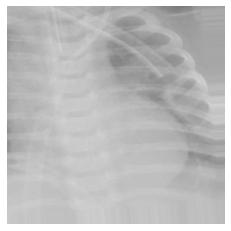

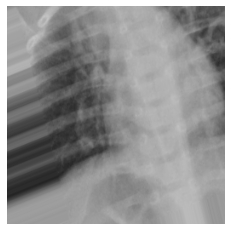

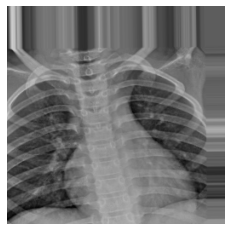

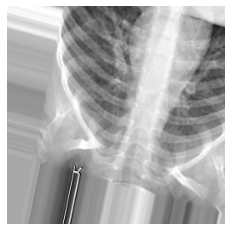

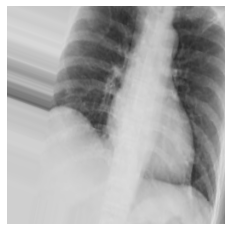

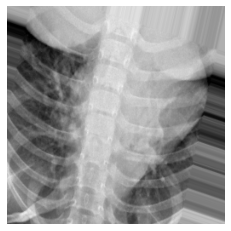

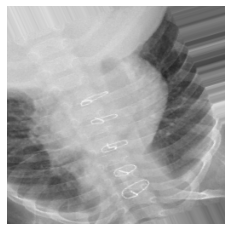

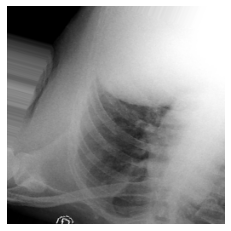

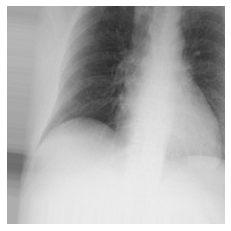

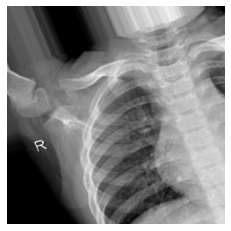

In [0]:
# Show some images with augmentation

for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size = 10):
  for i in range(10):
    plt.imshow(X_batch[i])
    plt.axis('off')
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/Show images/Augmented/' + str(i) + '.png',
     #           bbox_inches = 'tight', pad_inches = 0)
    plt.show()
  break

## Build the model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers

Using TensorFlow backend.


### Create the model

#### First model : hand-crafted

In [0]:
def create_model(img_width, img_height):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width,img_height,3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  return model

In [0]:
model = create_model(img_width, img_height)

# Let's see what the model looks like
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)     

#### Second model : Transfer Learning on Resnet

In [0]:
from keras.applications import ResNet50V2

In [0]:
# This is the model we will use - Resnet and a small top

def create_model_Resnet():
  model = Sequential()
  model.add(ResNet50V2(include_top = False, pooling = 'avg', weights = 'imagenet'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation = 'softmax'))
  return model

model = create_model_Resnet()

# Let's see what the model looks like
model.summary()

94674944/94668760 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 24,615,940
Trainable params: 24,570,500
Non-trainable params: 45,440
_________________________________________________________________


### Train the model

In [0]:
train_step = train_generator.n//train_generator.batch_size
valid_step = valid_generator.n//valid_generator.batch_size
test_step = test_generator.n//test_generator.batch_size

In [0]:
# We start by training the top of the model (for the second model)
model.layers[0].trainable = False

model.compile(optimizer = optimizers.SGD(lr=1e-4, momentum=0.9), # or 'Nadam'
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

# If data is loaded with flow_from_dataframe, use loss = 'categorical_crossentropy' and metrics = ['accuracy'] instead

In [0]:
nb_epochs_top = 30 

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = train_step,
                              validation_data = valid_generator,
                              validation_steps = valid_step,
                              epochs = nb_epochs_top)

Epoch 1/30
24/24 [==============================] - 17s 722ms/step - loss: 1.5456 - sparse_categorical_accuracy: 0.2659 - val_loss: 1.6262 - val_sparse_categorical_accuracy: 0.1858
Epoch 2/30
24/24 [==============================] - 15s 642ms/step - loss: 1.4044 - sparse_categorical_accuracy: 0.3175 - val_loss: 1.2007 - val_sparse_categorical_accuracy: 0.3127
Epoch 3/30
24/24 [==============================] - 15s 633ms/step - loss: 1.3364 - sparse_categorical_accuracy: 0.3598 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.3422
Epoch 4/30
24/24 [==============================] - 15s 634ms/step - loss: 1.3778 - sparse_categorical_accuracy: 0.3516 - val_loss: 0.9491 - val_sparse_categorical_accuracy: 0.3746
Epoch 5/30
24/24 [==============================] - 15s 611ms/step - loss: 1.3501 - sparse_categorical_accuracy: 0.3683 - val_loss: 0.9345 - val_sparse_categorical_accuracy: 0.3805
Epoch 6/30
24/24 [==============================] - 15s 610ms/step - loss: 1.2372 - sparse_cate

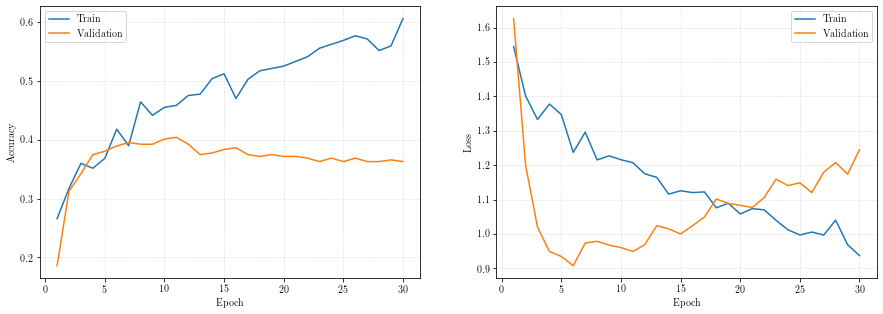

In [0]:
# Plot loss and accuracy of training

E = [k+1 for k in range(nb_epochs_top)]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
#fig.suptitle('Model loss and accuracy')

ax1.plot(E, history.history['sparse_categorical_accuracy'])
ax1.plot(E, history.history['val_sparse_categorical_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])
ax1.grid(lw = 0.5, ls = 'dotted')
    
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)

ax2.plot(E, history.history['loss'])
ax2.plot(E, history.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])
ax2.grid(lw = 0.5, ls = 'dotted');

#plt.savefig('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/plot_top.pdf')

In [0]:
# Then we fine-tune the whole model (for the second model)
model.layers[0].trainable = True

model.compile(optimizer = optimizers.SGD(lr=1e-4, momentum=0.9),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [0]:
nb_epochs_whole = 40

history2 = model.fit_generator(generator = train_generator,
                    steps_per_epoch = train_step,
                    validation_data = valid_generator,
                    validation_steps = valid_step,
                    epochs = nb_epochs_whole)

Epoch 1/40
24/24 [==============================] - 31s 1s/step - loss: 0.9534 - sparse_categorical_accuracy: 0.5899 - val_loss: 0.6288 - val_sparse_categorical_accuracy: 0.4720
Epoch 2/40
24/24 [==============================] - 21s 862ms/step - loss: 0.9599 - sparse_categorical_accuracy: 0.5833 - val_loss: 0.2862 - val_sparse_categorical_accuracy: 0.5575
Epoch 3/40
24/24 [==============================] - 21s 861ms/step - loss: 0.9178 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.2414 - val_sparse_categorical_accuracy: 0.5870
Epoch 4/40
24/24 [==============================] - 21s 866ms/step - loss: 0.8721 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.1997 - val_sparse_categorical_accuracy: 0.5575
Epoch 5/40
24/24 [==============================] - 21s 874ms/step - loss: 0.8517 - sparse_categorical_accuracy: 0.6349 - val_loss: 0.1879 - val_sparse_categorical_accuracy: 0.5988
Epoch 6/40
24/24 [==============================] - 21s 886ms/step - loss: 0.8453 - sparse_categor

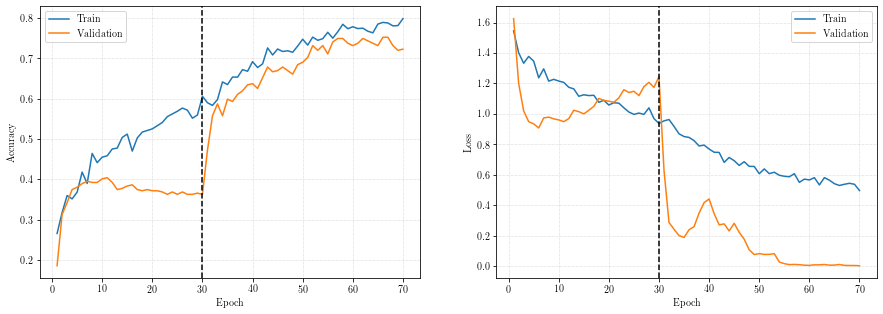

In [0]:
# Plot loss and accuracy of the full training (delimit time when we unfreeze lower layers)

E = [k+1 for k in range(nb_epochs_top + nb_epochs_whole)]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.plot(E, history.history['sparse_categorical_accuracy'] + history2.history['sparse_categorical_accuracy'])
ax1.plot(E, history.history['val_sparse_categorical_accuracy'] + history2.history['val_sparse_categorical_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])
ax1.grid(lw = 0.5, ls = 'dotted')
ax1.axvline(x = nb_epochs_top, ls = '--', color = 'black')

ax2.plot(E, history.history['loss'] + history2.history['loss'])
ax2.plot(E, history.history['val_loss'] + history2.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])
ax2.grid(lw = 0.5, ls = 'dotted')
ax2.axvline(x = nb_epochs_top, ls = '--', color = 'black');

#plt.savefig('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/plot_whole.pdf')

In [0]:
# If we want to save the model 

model.save('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/best_model.h5')

## Metrics and predictions

In [0]:
# Load model

from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/best_model.h5')

### Useful functions

In [0]:
def predict_labels(preds, n_test, privilege_covid = False, epsilon = 0.1):
  # privileges covid at scale epsilon
  if privilege_covid:
    label_ind_pred = np.zeros(n_test)
    for k in range(n_test):
      m = np.max(preds[k])
      if preds[k][1] > m - epsilon:
        label_ind_pred[k] = 1
      else:
        label_ind_pred[k] = np.argmax(preds[k])
  
  else:
    label_ind_pred = np.argmax(preds, axis=1)
  
  return label_ind_pred

In [0]:
def heatmap(mat, x_labels, y_labels, cmap = plt.cm.OrRd, title = None, filename = None):
  m = (np.max(mat) + np.min(mat))/2

  fig, ax = plt.subplots()
  cax = ax.matshow(mat, cmap = cmap, aspect = 'auto')
  ax.xaxis.set_ticks_position('bottom')
  ax.set_xticks(np.arange(len(x_labels)))
  ax.set_yticks(np.arange(len(y_labels)))
  ax.set_xticklabels(x_labels)
  ax.set_yticklabels(y_labels)

  for i in range(len(x_labels)):
      for j in range(len(y_labels)):
          c = round(mat[j,i], 2)
          if c > m:
            ax.text(i, j, str(c), va = 'center', ha = 'center', color = 'w')
          else:
            ax.text(i, j, str(c), va = 'center', ha = 'center')
  if title != None:
    ax.set_title(title)
  fig.colorbar(cax)
  
  fig.tight_layout()
  if filename != None:
    plt.savefig(filename + '.pdf')

  return

### Metrics

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Make predictions on the validation dataset

valid_generator.reset()
preds = model.predict_generator(generator = valid_generator, steps = valid_generator.n)

In [0]:
label_ind_pred = predict_labels(preds, valid_generator.n)

#### Confusion Matrix

In [0]:
C = confusion_matrix(y_val, label_ind_pred)
C = C/C.sum(axis=1)

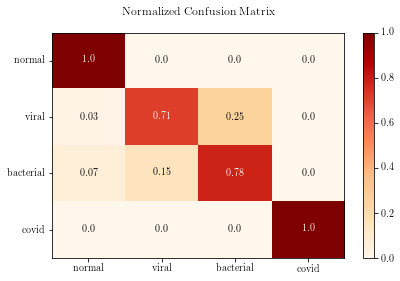

In [0]:
heatmap(C, classes, classes, title = 'Normalized Confusion Matrix')

#### Classification Report

In [0]:
print(classification_report(y_val, label_ind_pred, target_names=classes))

              precision    recall  f1-score   support

      normal       0.91      1.00      0.95       105
       viral       0.82      0.71      0.77       105
   bacterial       0.75      0.78      0.77       106
       covid       1.00      1.00      1.00        23

    accuracy                           0.84       339
   macro avg       0.87      0.87      0.87       339
weighted avg       0.84      0.84      0.84       339



In [0]:
clf_report = classification_report(y_val,
                                   label_ind_pred,
                                   labels=np.arange(nb_classes),
                                   target_names=classes,
                                   output_dict=True)

In [0]:
acc = clf_report.pop('accuracy')
c_df = pd.DataFrame(clf_report).iloc[:-1, :].T
c_array = np.array(c_df)

Accuracy : 0.84


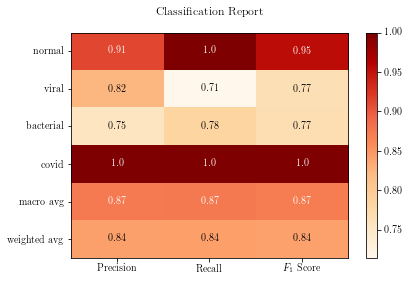

In [0]:
print('Accuracy : {:.2f}'.format(acc))
heatmap(c_array, ['Precision', 'Recall', '$F_1$ Score'], c_df.index.values, title = 'Classification Report',
        path = '/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/class_report')

#### Misclassified images

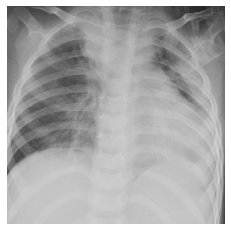

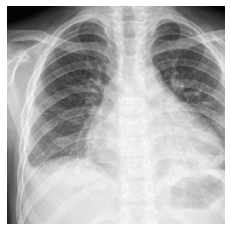

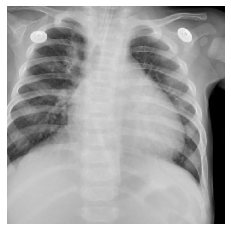

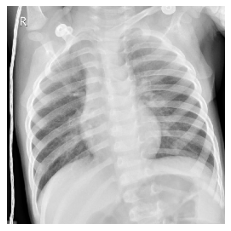

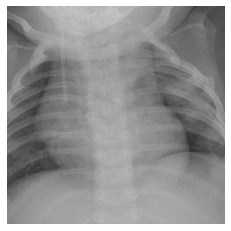

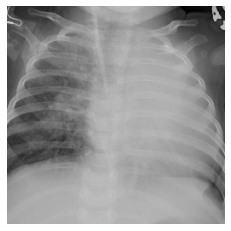

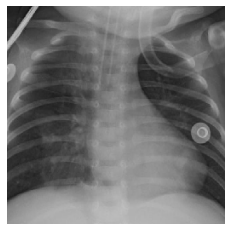

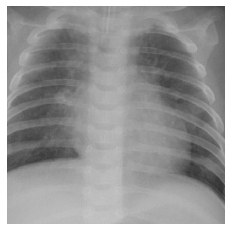

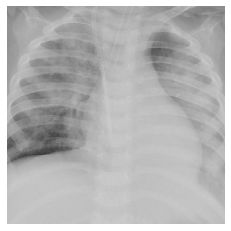

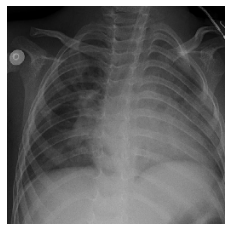

In [0]:
# See why examples are misclassified

n_val = len(y_val)

cpt = 0
for i in range(n_val):
  if y_val[i] == 1 and label_ind_pred[i] == 2 and cpt < 10: # predicted bacterial when actually viral
    plt.imshow(X_val[i])
    plt.axis('off')
    cpt += 1
    plt.show()

### Predictions

In [0]:
test_generator.reset()
preds = model.predict_generator(generator = test_generator, steps = test_step)

In [0]:
label_ind_pred = predict_labels(preds, n_test) # privilege_covid = True

convert_labels = {0 : 'bacterial', 1 : 'covid', 2 : 'normal', 3 : 'viral'}
final_pred = [convert_labels[k] for k in label_ind_pred]

### Write predictions in CSV format

In [0]:
filenames = test_generator.filenames
results = pd.DataFrame({'Id' : test_data['id'], 'label' : final_pred})
results.to_csv('/content/drive/My Drive/Colab Notebooks/COMS4771_Kaggle_Competition/submission.csv', index = False)